# Homework #1 - Text classification

NOTE: For the required "Report.pdf", please refer the to the Report.md in the hw1 folder.

In [1]:
# Import libraries
import os
import spacy
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from textblob import TextBlob
from nltk.sentiment import SentimentIntensityAnalyzer
import gensim
from gensim import corpora
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation as LDA
import re
import string
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

In [2]:
import nltk
import ssl

try:
    _create_unverified_https_context = ssl._create_unverified_context
except AttributeError:
    pass
else:
    ssl._create_default_https_context = _create_unverified_https_context

nltk.download()

showing info https://raw.githubusercontent.com/nltk/nltk_data/gh-pages/index.xml


True

In [3]:
#Import for pre-processing
import nltk
from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer

In [4]:
# Load and Preprocess the Data
def load_data(directory, limit_per_category=100):
    texts = []
    labels = []
    for category in ['business', 'entertainment', 'politics', 'sport', 'tech']:
        cat_dir = os.path.join(directory, category)
        files = os.listdir(cat_dir)[:limit_per_category]
        for file in files:
            with open(os.path.join(cat_dir, file), encoding='utf-8') as f:
                texts.append(f.read())
                labels.append(category)
    return texts, labels

texts, labels = load_data('/Users/apple/Desktop/2024 Spring/94812-NLXLLM/bbc')  # Replace with your folder path


In [5]:
texts[0], labels[0]

('UK economy facing \'major risks\'\n\nThe UK manufacturing sector will continue to face "serious challenges" over the next two years, the British Chamber of Commerce (BCC) has said.\n\nThe group\'s quarterly survey of companies found exports had picked up in the last three months of 2004 to their best levels in eight years. The rise came despite exchange rates being cited as a major concern. However, the BCC found the whole UK economy still faced "major risks" and warned that growth is set to slow. It recently forecast economic growth will slow from more than 3% in 2004 to a little below 2.5% in both 2005 and 2006.\n\nManufacturers\' domestic sales growth fell back slightly in the quarter, the survey of 5,196 firms found. Employment in manufacturing also fell and job expectations were at their lowest level for a year.\n\n"Despite some positive news for the export sector, there are worrying signs for manufacturing," the BCC said. "These results reinforce our concern over the sector\'s 

In [6]:
def preprocess_text(text):
    # Convert text to lowercase
    text = text.lower()
    # remove \n
    text = text.replace('\n', '')
    # Remove punctuation
    text = re.sub(f'[{re.escape(string.punctuation)}]', '', text)
    # Remove numbers
    text = re.sub(r'\d+', '', text)
    # Tokenization
    tokens = word_tokenize(text)
    # Remove stopwords and perform lemmatization
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stopwords.words('english')]
    # Join tokens back to string
    text = ' '.join(tokens)
    return text

preprocessed_texts = [preprocess_text(text) for text in texts]

## Named Entity Recognition

In [7]:
nlp = spacy.load('en_core_web_sm')

def named_entity_recognition(texts):
    entities = []
    for doc in nlp.pipe(texts):
        doc_entities = [(ent.text, ent.label_) for ent in doc.ents]
        entities.append(doc_entities)
    return entities

# ner_results is to store the named entity recognition results
ner_results = named_entity_recognition(preprocessed_texts)

In [8]:
from collections import defaultdict

# Group NER results by labels
ner_results_by_label = defaultdict(list)
for label, ner_result in zip(labels, ner_results):
    ner_results_by_label[label].extend(ner_result)


In [9]:
entity_counts = {label: defaultdict(int) for label in ner_results_by_label}

for label, entities in ner_results_by_label.items():
    for entity in entities:
        entity_type = entity[1]
        entity_counts[label][entity_type] += 1


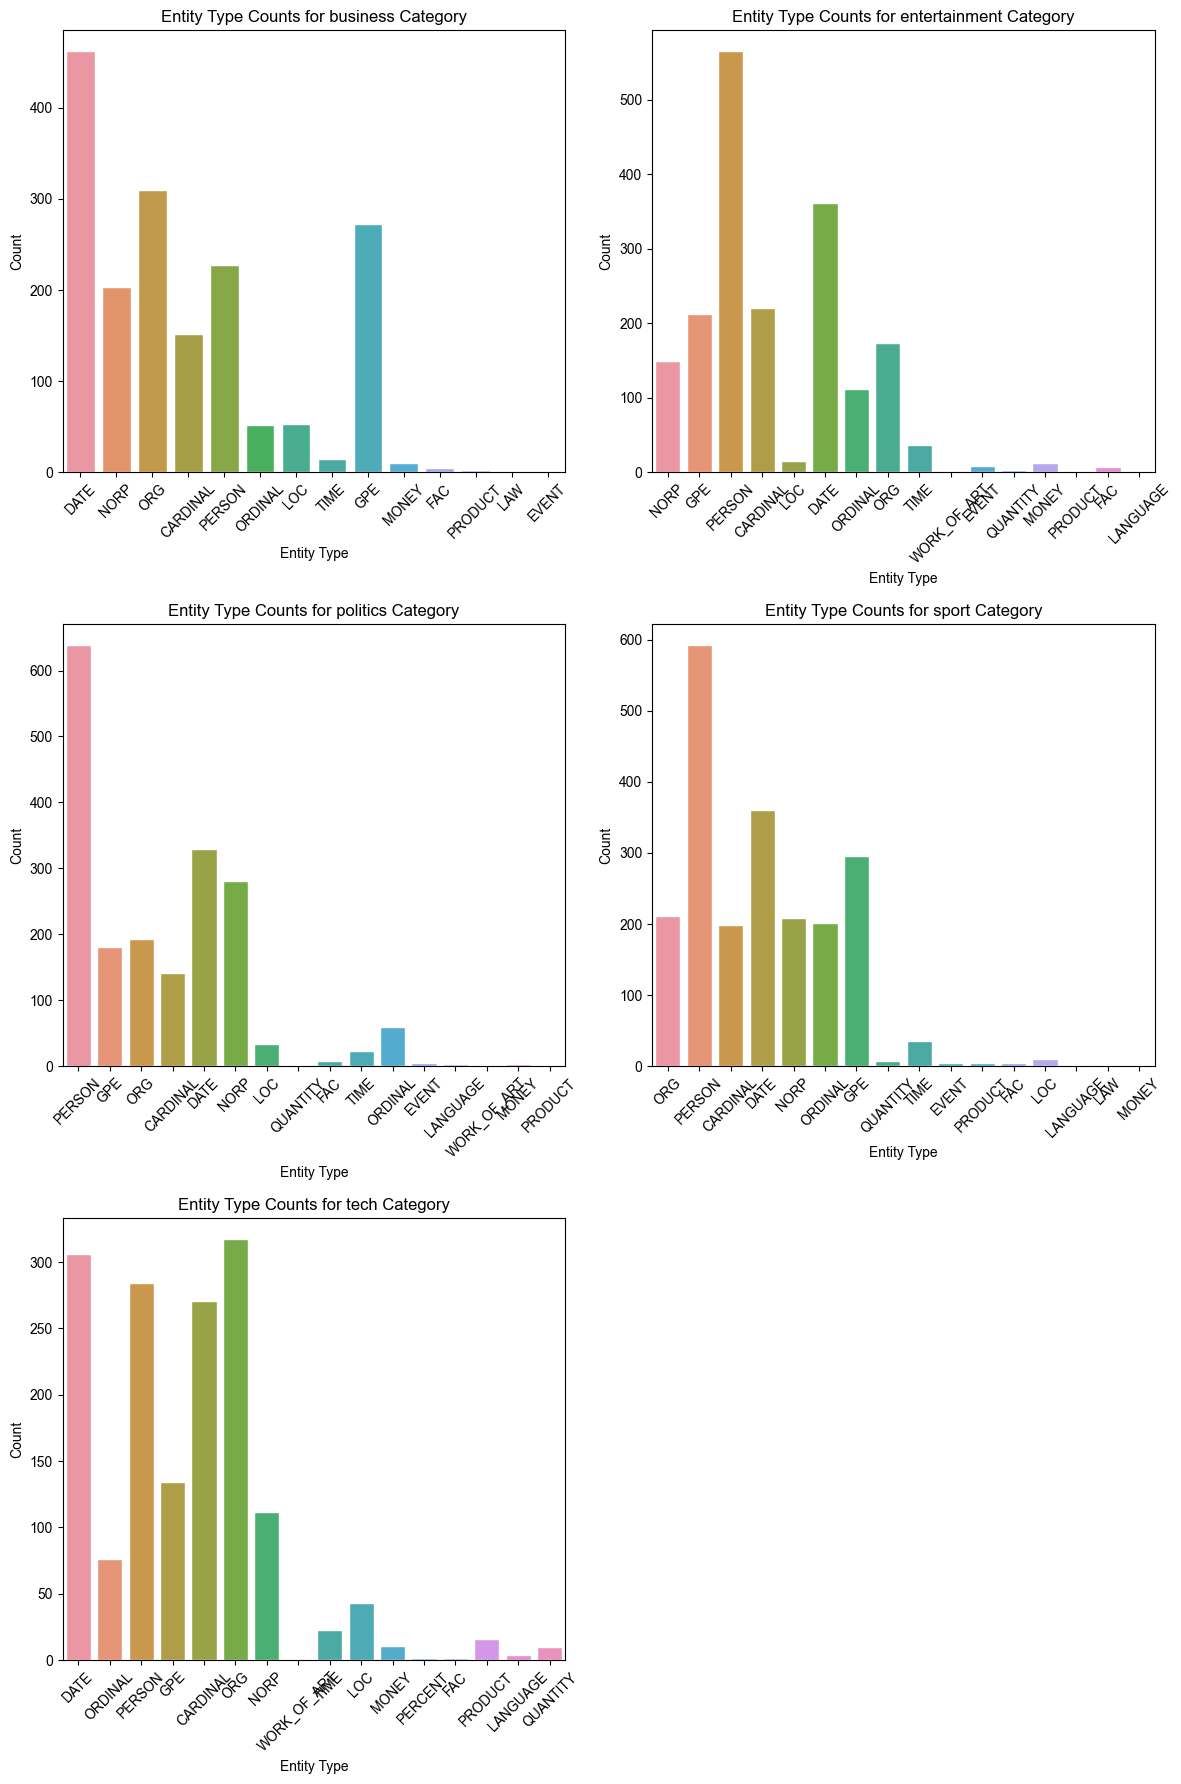

In [10]:
categories = list(entity_counts.keys())
num_categories = len(categories)
rows = 3
cols = 2

fig, axes = plt.subplots(rows, cols, figsize=(12, 18))  # Adjust the figure size as needed
sns.set(style="whitegrid")

for i, (label, counts) in enumerate(entity_counts.items()):
    ax = axes[i//cols, i%cols]  # Determine the row and column position
    sns.barplot(x=list(counts.keys()), y=list(counts.values()), ax=ax)
    ax.set_title(f"Entity Type Counts for {label} Category")
    ax.set_ylabel("Count")
    ax.set_xlabel("Entity Type")
    ax.tick_params(axis='x', rotation=45)

# If there are any empty subplots, hide them
for j in range(i+1, rows*cols):
    fig.delaxes(axes[j//cols, j%cols])

plt.tight_layout()
plt.show()


## Sentiment Analysis

In [11]:
# I first would like to see the difference between the two sentiment analysis methods
sia = SentimentIntensityAnalyzer()

# Assuming preprocessed_texts and labels are defined and aligned
category_sentiments = defaultdict(lambda: {'tb': [], 'vader': []})

for text, label in zip(preprocessed_texts, labels):
    tb_score = TextBlob(text).sentiment.polarity
    vader_score = sia.polarity_scores(text)['compound']

    category_sentiments[label]['tb'].append(tb_score)
    category_sentiments[label]['vader'].append(vader_score)

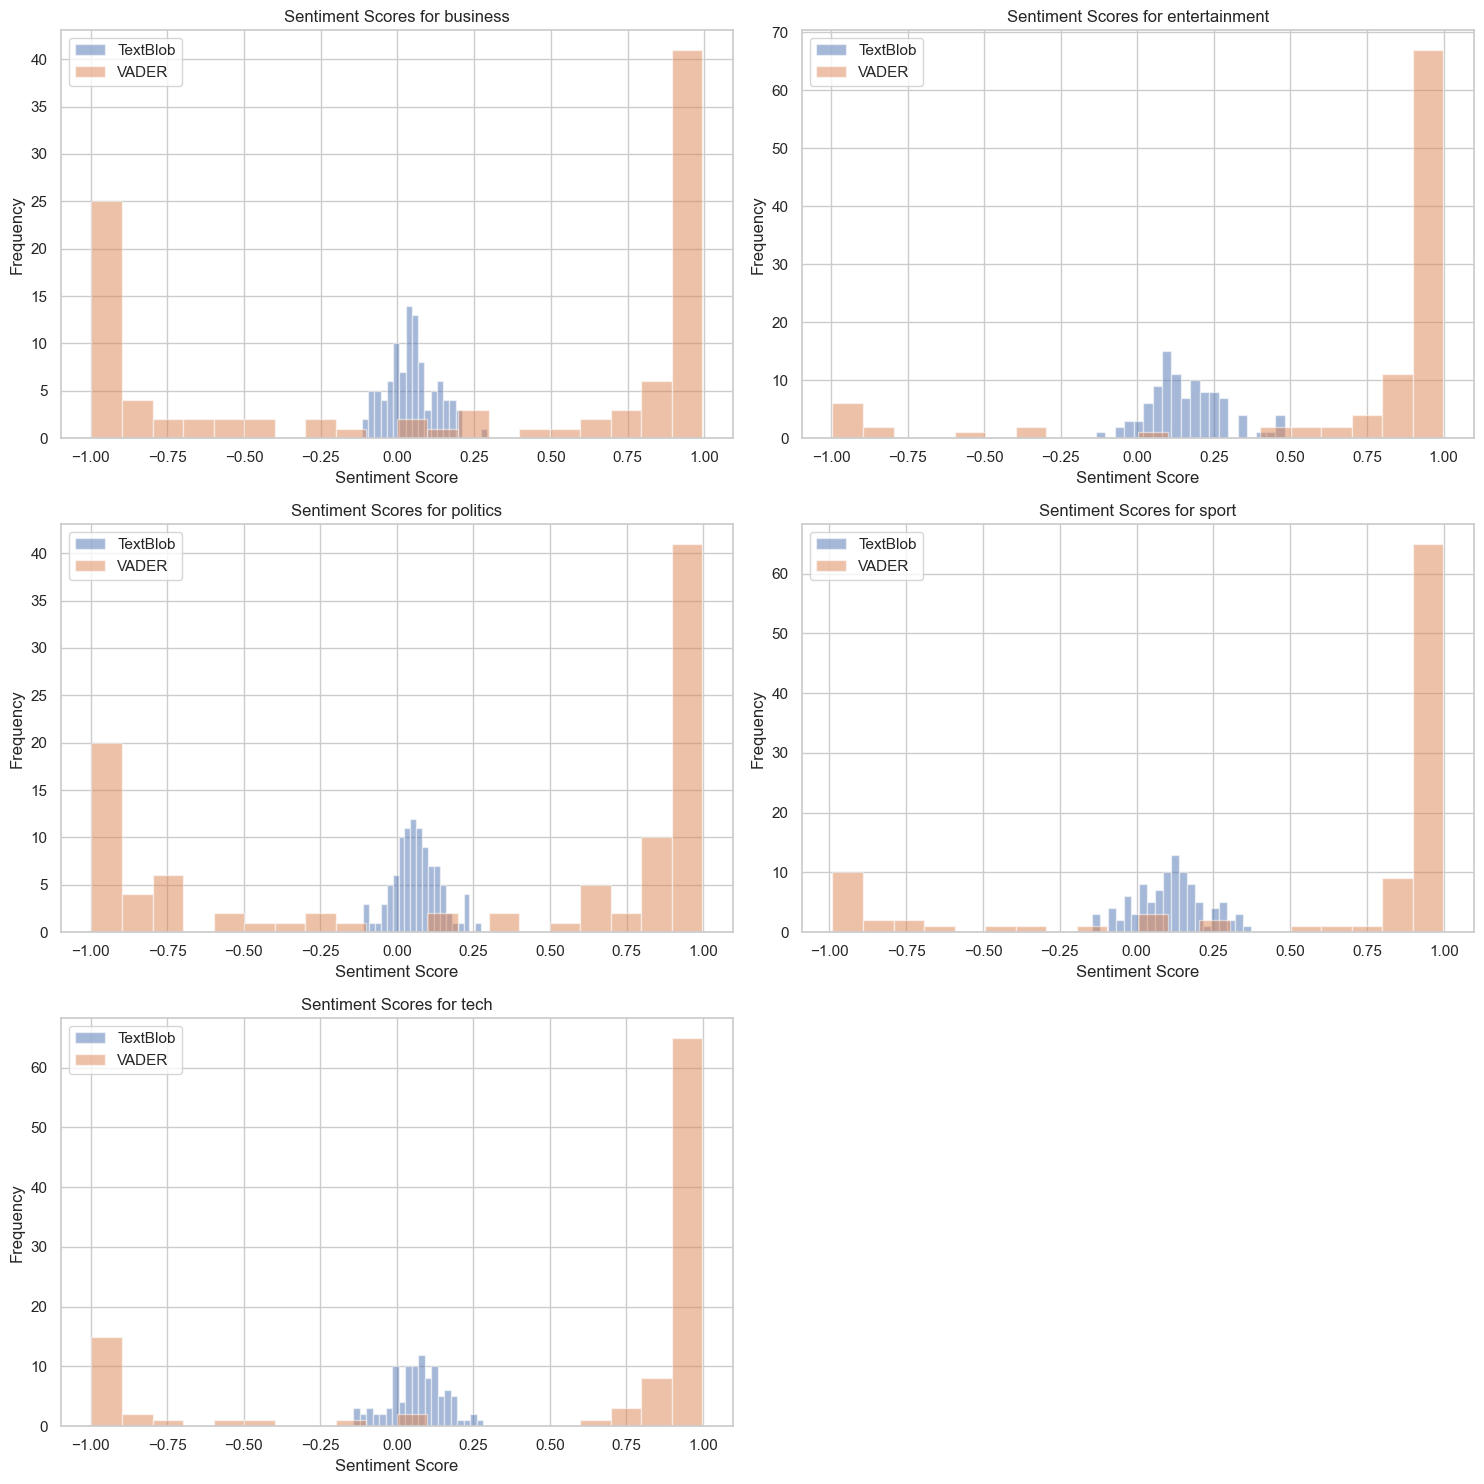

In [12]:
# Define the number of bins for histogram
bins = 20

# Create a 3x2 grid of subplots
fig, axs = plt.subplots(3, 2, figsize=(15, 15))
axs = axs.flatten()

for i, (category, sentiments) in enumerate(category_sentiments.items()):
    # Overlaying histograms for TextBlob and VADER
    axs[i].hist(sentiments['tb'], bins=bins, alpha=0.5, label='TextBlob')
    axs[i].hist(sentiments['vader'], bins=bins, alpha=0.5, label='VADER')
    
    axs[i].set_title(f"Sentiment Scores for {category}")
    axs[i].set_xlabel("Sentiment Score")
    axs[i].set_ylabel("Frequency")
    axs[i].legend()

# If there's an odd number of categories, hide the last subplot
if len(category_sentiments) % 2 != 0:
    axs[-1].axis('off')

plt.tight_layout()
plt.show()

In [13]:
def calculate_average_sentiments(texts, labels):
    tb_scores = defaultdict(list)
    vader_scores = defaultdict(list)

    for text, label in zip(texts, labels):
        tb_score = TextBlob(text).sentiment.polarity
        vader_score = sia.polarity_scores(text)['compound']

        tb_scores[label].append(tb_score)
        vader_scores[label].append(vader_score)

    # Calculate average scores
    avg_tb_scores = {label: np.mean(scores) for label, scores in tb_scores.items()}
    avg_vader_scores = {label: np.mean(scores) for label, scores in vader_scores.items()}

    return avg_tb_scores, avg_vader_scores

avg_tb_scores, avg_vader_scores = calculate_average_sentiments(preprocessed_texts, labels)


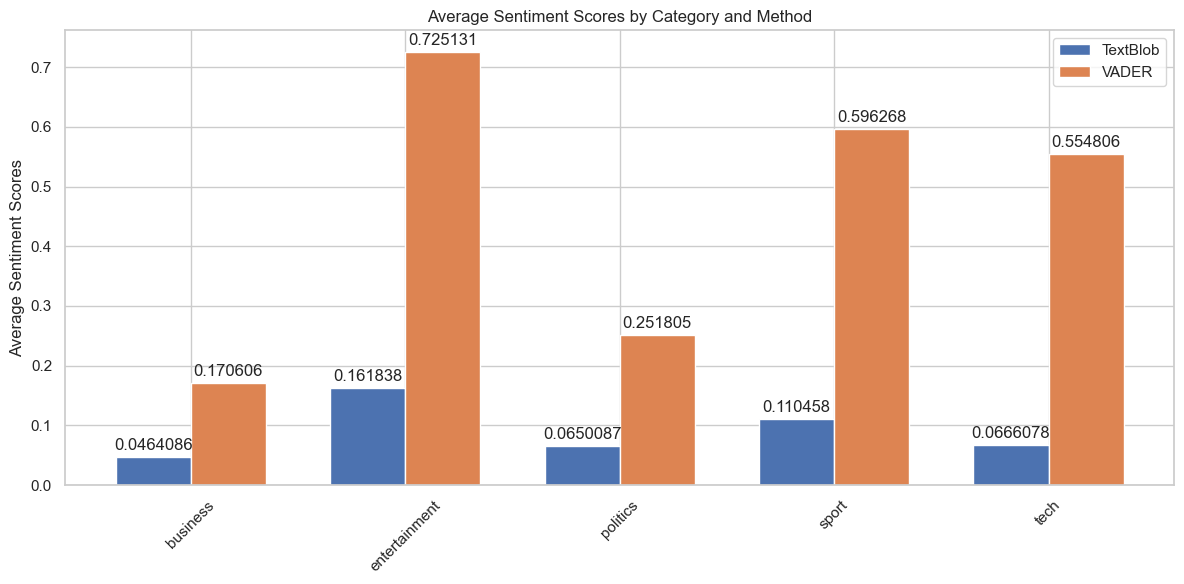

In [14]:
import matplotlib.pyplot as plt

categories = sorted(avg_tb_scores.keys())
tb_values = [avg_tb_scores[cat] for cat in categories]
vader_values = [avg_vader_scores[cat] for cat in categories]

x = np.arange(len(categories))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots(figsize=(12, 6))
rects1 = ax.bar(x - width/2, tb_values, width, label='TextBlob')
rects2 = ax.bar(x + width/2, vader_values, width, label='VADER')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Average Sentiment Scores')
ax.set_title('Average Sentiment Scores by Category and Method')
ax.set_xticks(x)
ax.set_xticklabels(categories)
ax.legend()

ax.bar_label(rects1, padding=3)
ax.bar_label(rects2, padding=3)

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


## Topic Modeling

In [15]:
def topic_modeling(texts, num_topics=5, num_words=10):
    vectorizer = CountVectorizer(max_df=0.95, min_df=2, stop_words='english')
    doc_term_matrix = vectorizer.fit_transform(texts)

    lda = LDA(n_components=num_topics, random_state=0)
    lda.fit(doc_term_matrix)

    topics = {}
    for i, topic in enumerate(lda.components_):
        topics[f"Topic {i}"] = [vectorizer.get_feature_names_out()[index] for index in topic.argsort()[-num_words:]]
    
    # Return both the model and the vectorizer along with the topics
    return lda, vectorizer, topics


# Call the modified function and store the results
lda_model, vectorizer, topics = topic_modeling(preprocessed_texts, num_topics=5, num_words=10)


In [16]:
texts_by_category = defaultdict(list)
for label, text in zip(labels, preprocessed_texts):
    texts_by_category[label].append(text)

# Now, create a dictionary to store the LDA models by category
lda_models_by_category = {}

# Run LDA for each category and store the models and top words for topics
for category, texts in texts_by_category.items():
    lda_model, vectorizer, topics = topic_modeling(texts)
    lda_models_by_category[category] = {
        'model': lda_model,
        'vectorizer': vectorizer,
        'topics': topics
    }

# Now we can print the top 5 topics for each category
for category, model_details in lda_models_by_category.items():
    print(f"Top 5 topics for {category}:")
    for topic_num, words in model_details['topics'].items():
        print(f"{topic_num}: {', '.join(words)}")
    print("\n")

Top 5 topics for business:
Topic 0: market, marsh, executive, bn, share, ebbers, firm, company, said, mr
Topic 1: price, quarter, rate, bank, growth, profit, economy, bn, year, said
Topic 2: exchange, euronext, bid, said, mr, lse, bush, deficit, budget, bn
Topic 3: country, turkey, government, year, new, said, bn, sale, china, bank
Topic 4: hit, euro, price, disaster, stock, company, year, dollar, market, said


Top 5 topics for entertainment:
Topic 0: starring, box, cent, say, festival, sequel, european, said, year, film
Topic 1: comedy, new, role, actor, box, office, star, year, said, film
Topic 2: chart, lee, star, new, uk, year, sale, film, music, said
Topic 3: rock, song, hit, band, best, year, music, number, said, album
Topic 4: actor, musical, star, event, director, year, festival, film, award, best


Top 5 topics for politics:
Topic 0: home, year, plan, people, make, lord, new, government, mr, said
Topic 1: brown, election, government, party, tory, council, labour, mr, tax, sai